# Prediction for type of Breast Cancer

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.cluster import DBSCAN

OUTPUT = 1
DROP = False
IQR_OPTION = 2
USE_IQR = True

data = pd.read_csv("breast-cancer.csv")
diagnosis = data['diagnosis']
columns = list(data)
columns = columns[2:]

In [135]:
if OUTPUT:
    print(data.head())

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

In [136]:
if OUTPUT:
    num_rows = len(data.index)
    num_cols = len(data.columns)

    print(f"Number of features: {num_cols}")
    print(f"Number of entries: {num_rows}")


Number of features: 32
Number of entries: 569


In [137]:
if OUTPUT:
    print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [138]:
if OUTPUT:
    print(data.describe())

                 id  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  5.690000e+02   569.000000    569.000000      569.000000   569.000000   
mean   3.037183e+07    14.127292     19.289649       91.969033   654.889104   
std    1.250206e+08     3.524049      4.301036       24.298981   351.914129   
min    8.670000e+03     6.981000      9.710000       43.790000   143.500000   
25%    8.692180e+05    11.700000     16.170000       75.170000   420.300000   
50%    9.060240e+05    13.370000     18.840000       86.240000   551.100000   
75%    8.813129e+06    15.780000     21.800000      104.100000   782.700000   
max    9.113205e+08    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813     

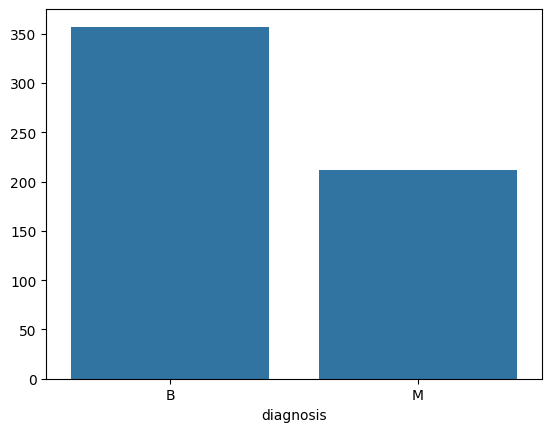

In [139]:
if OUTPUT:
    plt.figure()
    class_count = diagnosis.value_counts()
    sns.barplot(x=class_count.index, y=class_count.values)

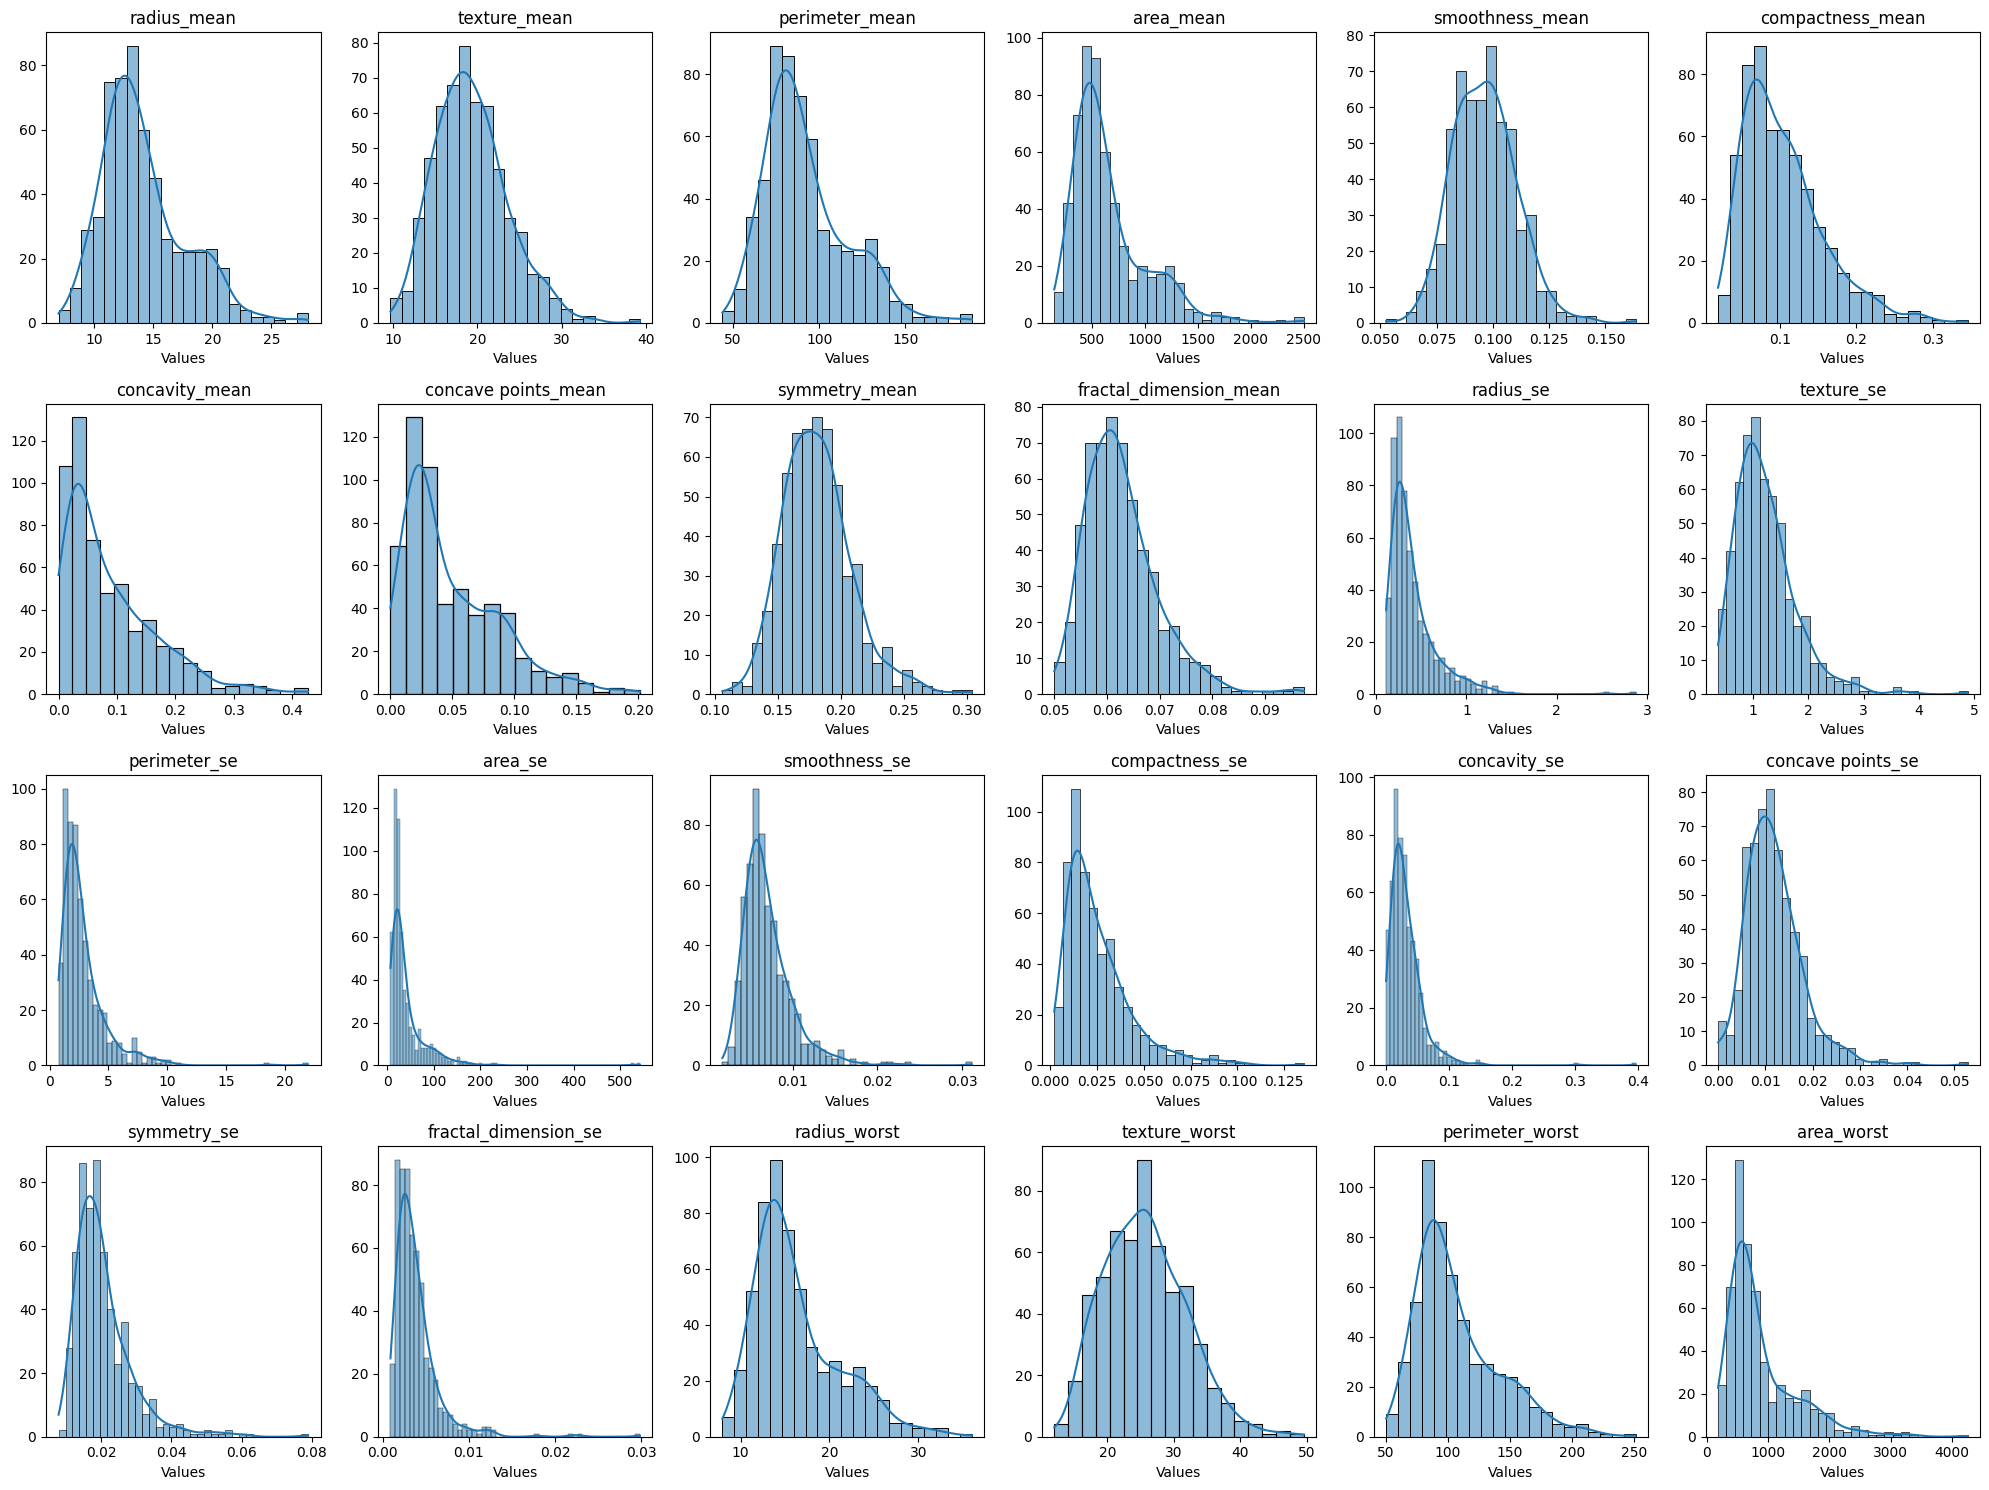

In [140]:
if OUTPUT:
    fig, axes = plt.subplots(4, 6, figsize=(20, 15))
    axes = axes.flatten()

    for i, ax in enumerate(axes[:data.shape[1]]):
        sns.histplot(data.iloc[:, i + 2], kde=True, ax=ax)
        ax.set_title(f"{columns[i]}")
        ax.set_xlabel("Values")
        ax.set_ylabel("")

    for ax in axes[data.shape[1]:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


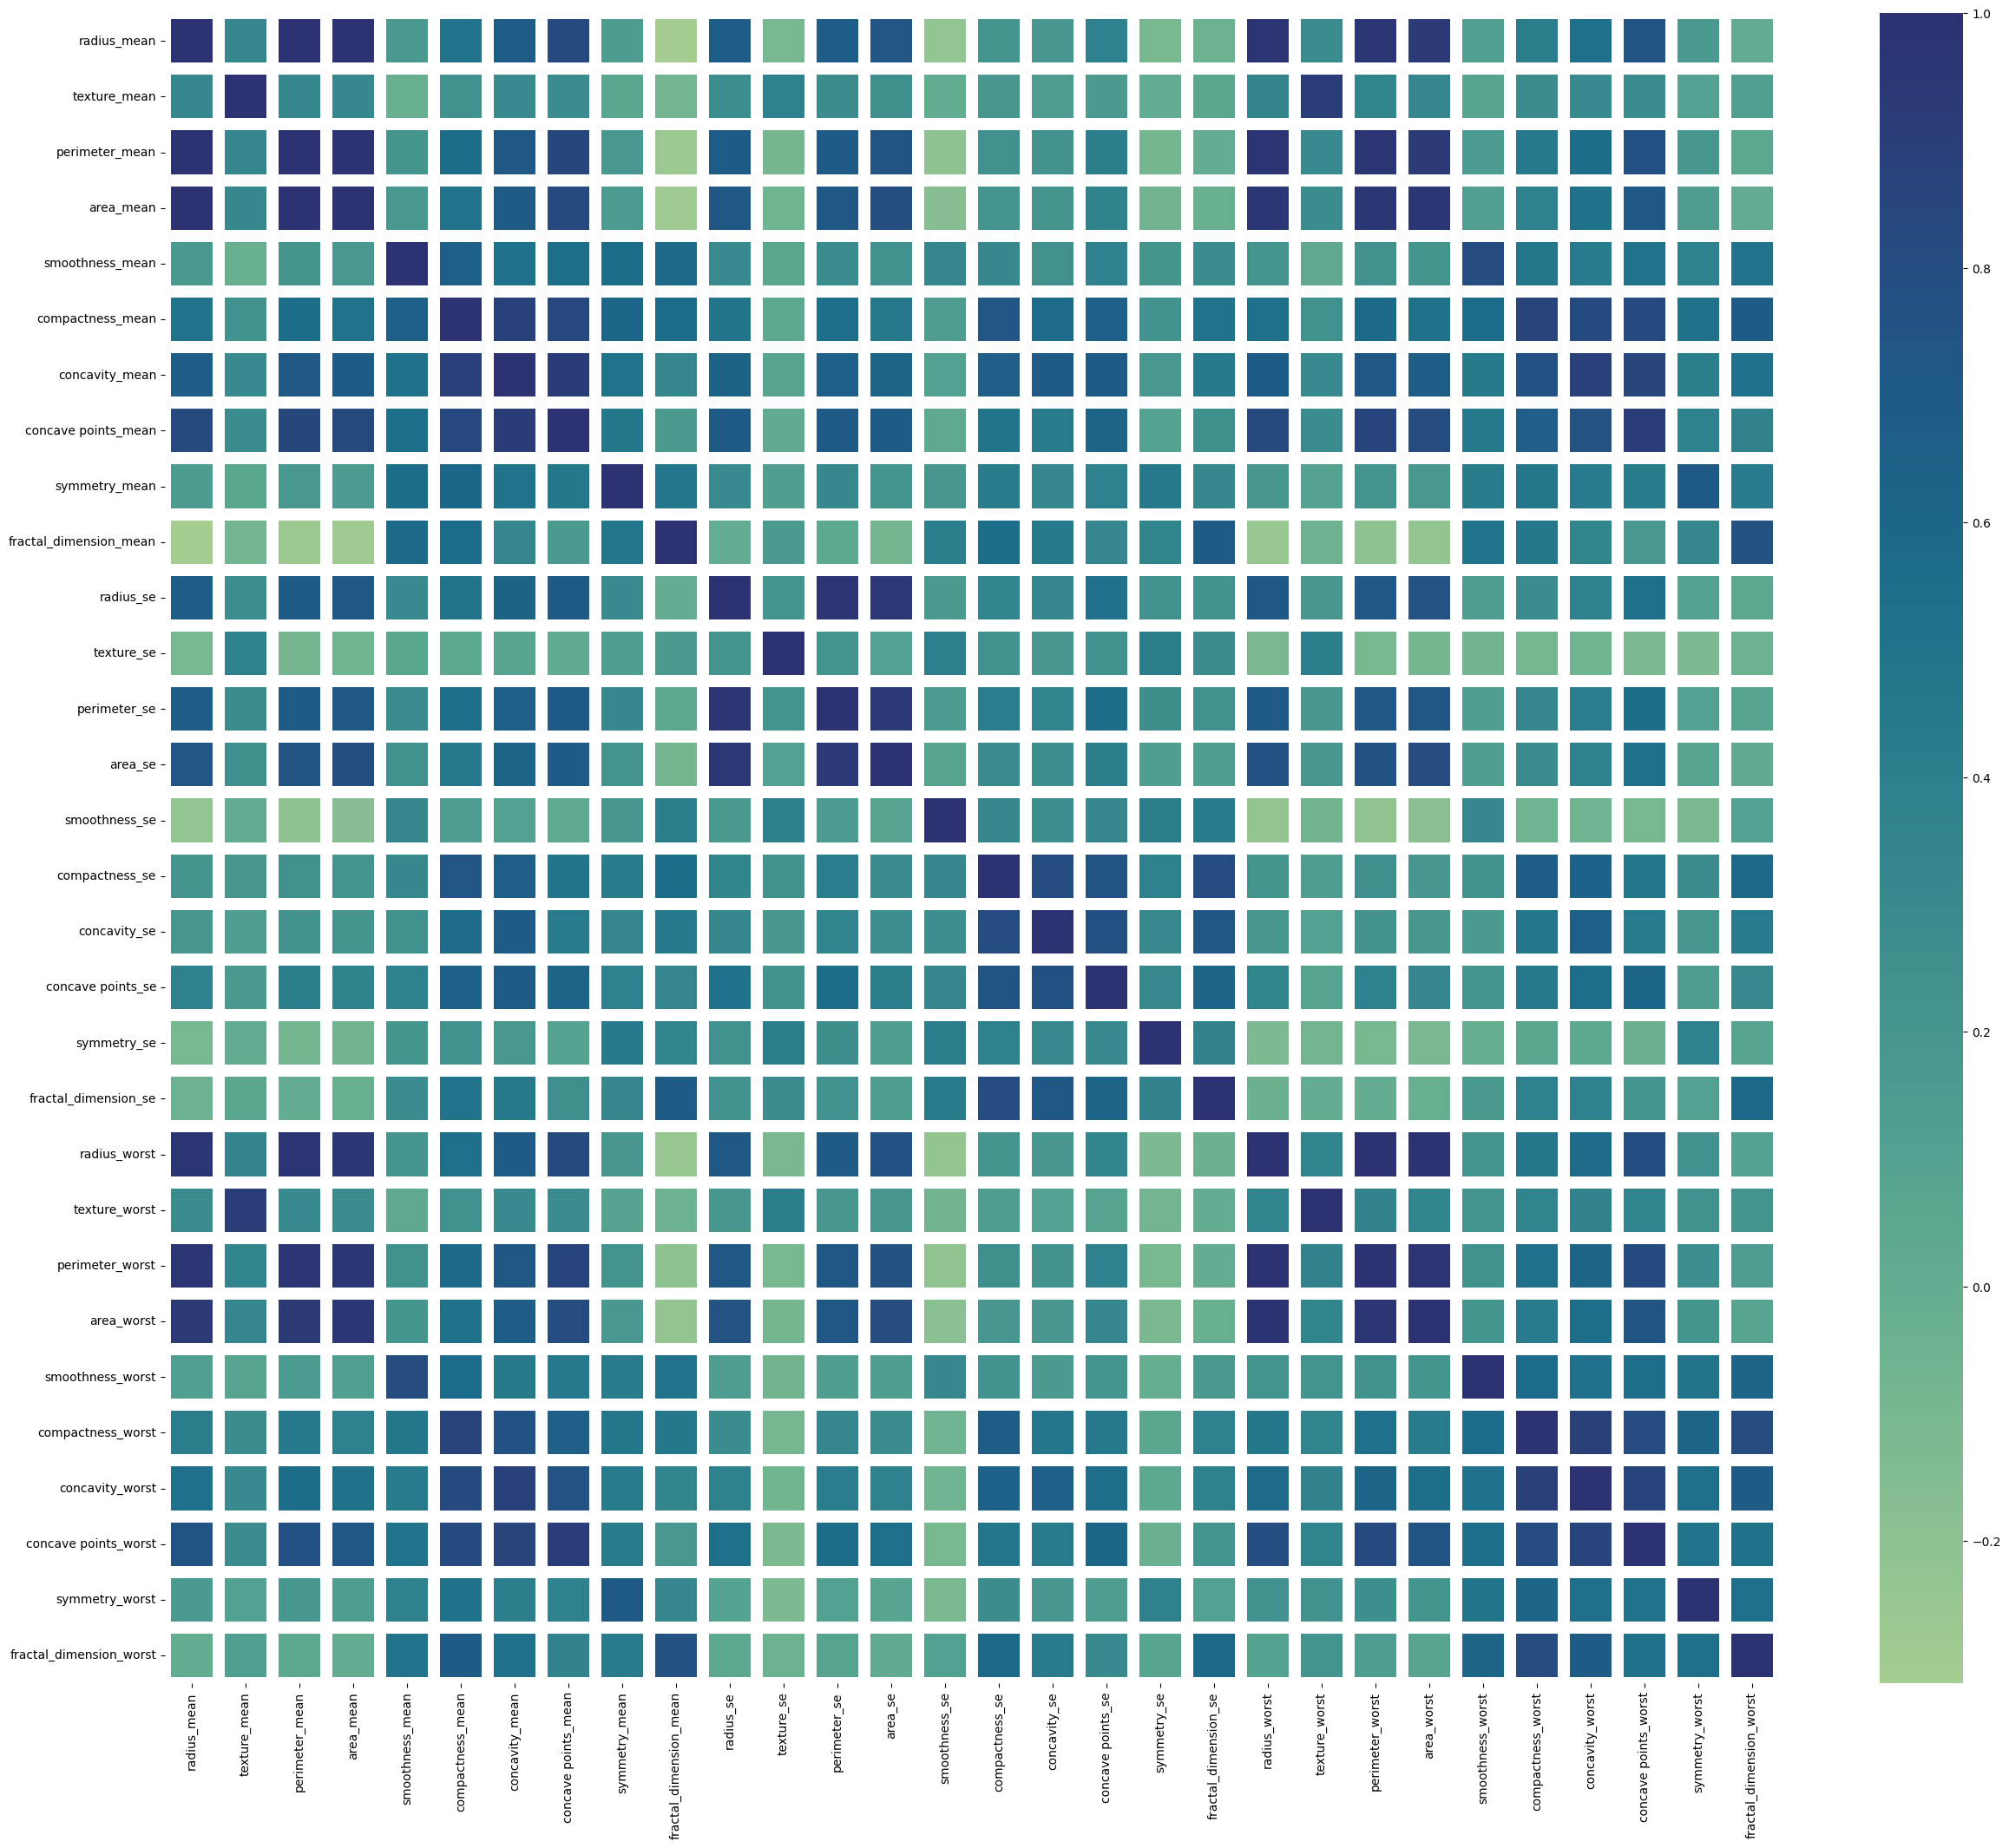

In [141]:
if OUTPUT:
    plt.figure(figsize=(30,25))
    sns.heatmap(data=(data.iloc[:, 2:]).corr(), linewidths=10, cmap='crest')

# Phase 1: Data Preprocessing

### Remove ID column

In [142]:
data = data.iloc[:, 1:]

### Check if there are any empty values

In [143]:
if OUTPUT:
    print(data.isnull().any())

diagnosis                  False
radius_mean                False
texture_mean               False
perimeter_mean             False
area_mean                  False
smoothness_mean            False
compactness_mean           False
concavity_mean             False
concave points_mean        False
symmetry_mean              False
fractal_dimension_mean     False
radius_se                  False
texture_se                 False
perimeter_se               False
area_se                    False
smoothness_se              False
compactness_se             False
concavity_se               False
concave points_se          False
symmetry_se                False
fractal_dimension_se       False
radius_worst               False
texture_worst              False
perimeter_worst            False
area_worst                 False
smoothness_worst           False
compactness_worst          False
concavity_worst            False
concave points_worst       False
symmetry_worst             False
fractal_di

### Outlier Detection and Treatment

#### Using IQR

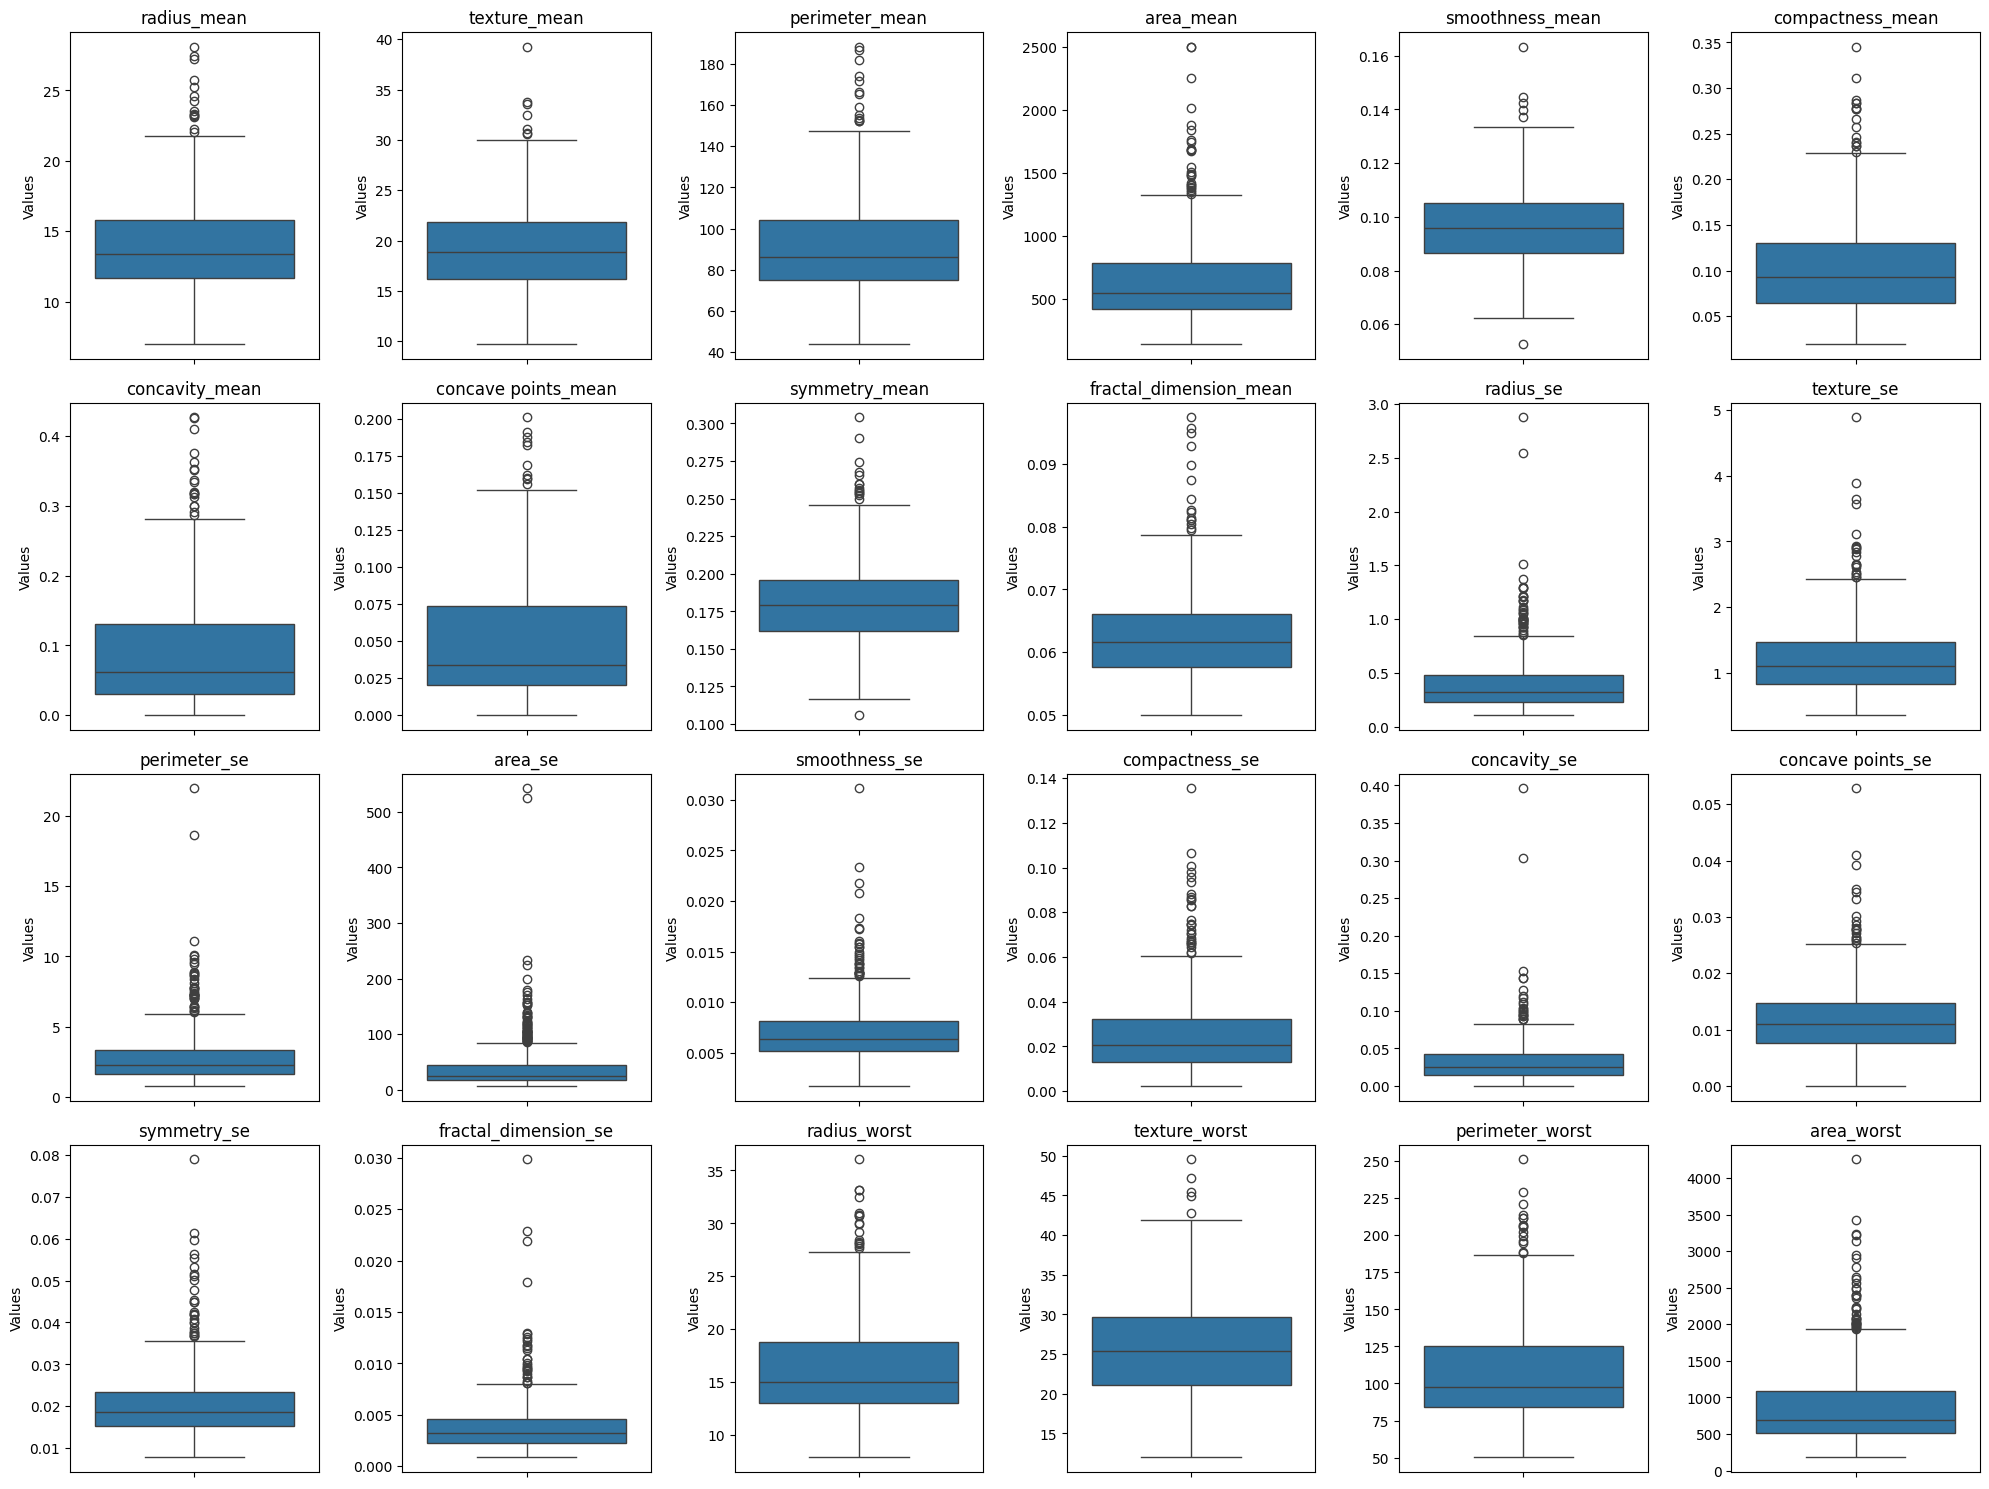

In [144]:
features = data.iloc[:, 1:]

if OUTPUT:
    fig, axes = plt.subplots(4, 6, figsize=(20, 15))
    axes = axes.flatten()

    for i, ax in enumerate(axes[:data.shape[1]]):
        sns.boxplot(y=data.iloc[:, i + 1], ax=ax)
        ax.set_title(f"{columns[i]}")
        ax.set_ylabel("Values")

    for ax in axes[data.shape[1]:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

##### IQR Option 1: Detect Outliers Based on All Values

In [145]:
if USE_IQR:
    if IQR_OPTION == 1:
        index = []

        for feature in features:
            values = data[feature].values
            q1 = np.percentile(values, 25)
            q2 = np.percentile(values, 50)
            q3 = np.percentile(values, 75)
            iqr = q3 - q1

            max = q3 + (1.5 * iqr)
            min = q1 - (1.5 * iqr)
            count = 0
            for i in range(len(values)):
                if values[i] > max or values[i] < min:
                    count += 1
                    index.append(i)
                    if not DROP:
                        if values[i] > max:
                            values[i] = max
                        else:
                            values[i] = min
            if OUTPUT:
                print(f"For {feature} there are {count} outliers")
            data[feature] = values

        if DROP:
            index = list(dict.fromkeys(index))
            if OUTPUT:
                print(f"Number of entries in old dataframe: {len(data)}")
            no_outliers_data = data.drop(index=index)
            if OUTPUT:
                print(f"Number of entries in new dataframe: {len(no_outliers_data)}")
            data = no_outliers_data.reset_index(drop=True)
            if OUTPUT:
                plt.figure()
                class_count = no_outliers_data['diagnosis'].value_counts()
                print(class_count)
                sns.barplot(x=class_count.index, y=class_count.values)

##### IQR Option 2: Detect Outliers Based on Diagnosis

In [146]:
if USE_IQR:
    if IQR_OPTION == 2:
        benign = data[data['diagnosis'] == 'B'].reset_index(drop=True)

        index = []
        features = list(benign)
        features = features[1:]
        for feature in features:
            values = benign[feature].values

            q1 = np.percentile(values, 25)
            q2 = np.percentile(values, 50)
            q3 = np.percentile(values, 75)
            iqr = q3 - q1

            max = q3 + (1.5 * iqr)
            min = q1 - (1.5 * iqr)
            count = 0
            for i in range(len(values)):
                if values[i] > max or values[i] < min:
                    count += 1
                    index.append(i)
                    if not DROP:
                        if values[i] > max:
                            values[i] = max
                        else:
                            values[i] = min
            benign[feature] = values


        if DROP:
            if OUTPUT:
                print(f"Number of benign cases before outlier removal {len(benign)}")
            index = list(dict.fromkeys(index))
            no_outliers_benign = benign.drop(index=index)
            if OUTPUT:
                print(f"Number of benign cases after outlier removal {len(no_outliers_benign)}")

In [147]:
if USE_IQR:
    if IQR_OPTION == 2:
        malignant = data[data['diagnosis'] == 'M'].reset_index(drop=True)


        index = []
        features = list(malignant)
        features = features[1:]
        for feature in features:
            values = malignant[feature].values

            q1 = np.percentile(values, 25)
            q2 = np.percentile(values, 50)
            q3 = np.percentile(values, 75)
            iqr = q3 - q1

            max = q3 + (1.5 * iqr)
            min = q1 - (1.5 * iqr)
            count = 0
            for i in range(len(values)):
                if values[i] > max or values[i] < min:
                    count += 1
                    index.append(i)
                    if not DROP:
                        if values[i] > max:
                            values[i] = max
                        else:
                            values[i] = min
            malignant[feature] = values

        if DROP:
            if OUTPUT:
                print(f"Number of malignant cases before outlier removal {len(benign)}")
            index = list(dict.fromkeys(index))
            no_outliers_malignant = malignant.drop(index=index)
            if OUTPUT:
                print(f"Number of malignant cases after outlier removal {len(no_outliers_malignant)}")

In [148]:
if USE_IQR:
    if IQR_OPTION == 2:
        if DROP:
            malignant = no_outliers_malignant
            benign = no_outliers_benign
            temp_df = pd.concat([malignant, benign], ignore_index=True)
            if OUTPUT:
                plt.figure()
                class_count = temp_df['diagnosis'].value_counts()
                print(class_count)
                sns.barplot(x=class_count.index, y=class_count.values)


        new_data = pd.concat([malignant, benign], ignore_index=True)
        data = new_data.sample(frac=1).reset_index(drop=True)





### Label Encoding

In [149]:
labelEncoder = LabelEncoder()
labelEncoder.fit(data['diagnosis'])
data['diagnosis'] = labelEncoder.transform(data['diagnosis'])
if OUTPUT:
    print(data['diagnosis'])

0      0
1      0
2      0
3      0
4      1
      ..
564    0
565    0
566    0
567    1
568    1
Name: diagnosis, Length: 569, dtype: int32


### Data Normalization

In [150]:
normalizer = MinMaxScaler(feature_range=(1, 10))
normalized = normalizer.fit_transform(data)
data = pd.DataFrame(normalized, columns=data.columns)
if OUTPUT:
    data

## Phase Two: Classification

In [151]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay


# Get the data of the features
x = data.drop(columns=['diagnosis'])

# Get the classes
y = data['diagnosis']

# Split the data into 80% training set and 20% testing set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

accuracy_scores= {
    'DecisionTree': -1,
    'KNN': -1,
    'GaussianNaiveBayes': -1,
    'DecisionForest': -1,
    'SVM': -1
}

# Function to plot the Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### Decision Tree

In [152]:
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30]
}

# Try to find the best parameters by changing the criterion and the maximum depth
dt_model = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=dt_model, param_grid=params, scoring='accuracy')
grid_search.fit(x_train, y_train)


dt_model = grid_search.best_estimator_


y_pred = dt_model.predict(x_test)
accuracy = accuracy_score(y_pred, y_test) * 100

accuracy_scores['DecisionTree'] = accuracy

if OUTPUT:
    print("The optimum parameters for Decision Tree is: ")
    print(f"\tCriterion: {grid_search.best_params_['criterion']}")
    print(f"\tMaximum Tree Depth: {grid_search.best_params_['max_depth']}")
    print(f"The accuracy: {accuracy:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    

The optimum parameters for Decision Tree is: 
	Criterion: entropy
	Maximum Tree Depth: 30
The accuracy: 94.74%
Classification Report:
              precision    recall  f1-score   support

         1.0       0.93      0.99      0.96        72
        10.0       0.97      0.88      0.93        42

    accuracy                           0.95       114
   macro avg       0.95      0.93      0.94       114
weighted avg       0.95      0.95      0.95       114



#### Decision Tree Plot

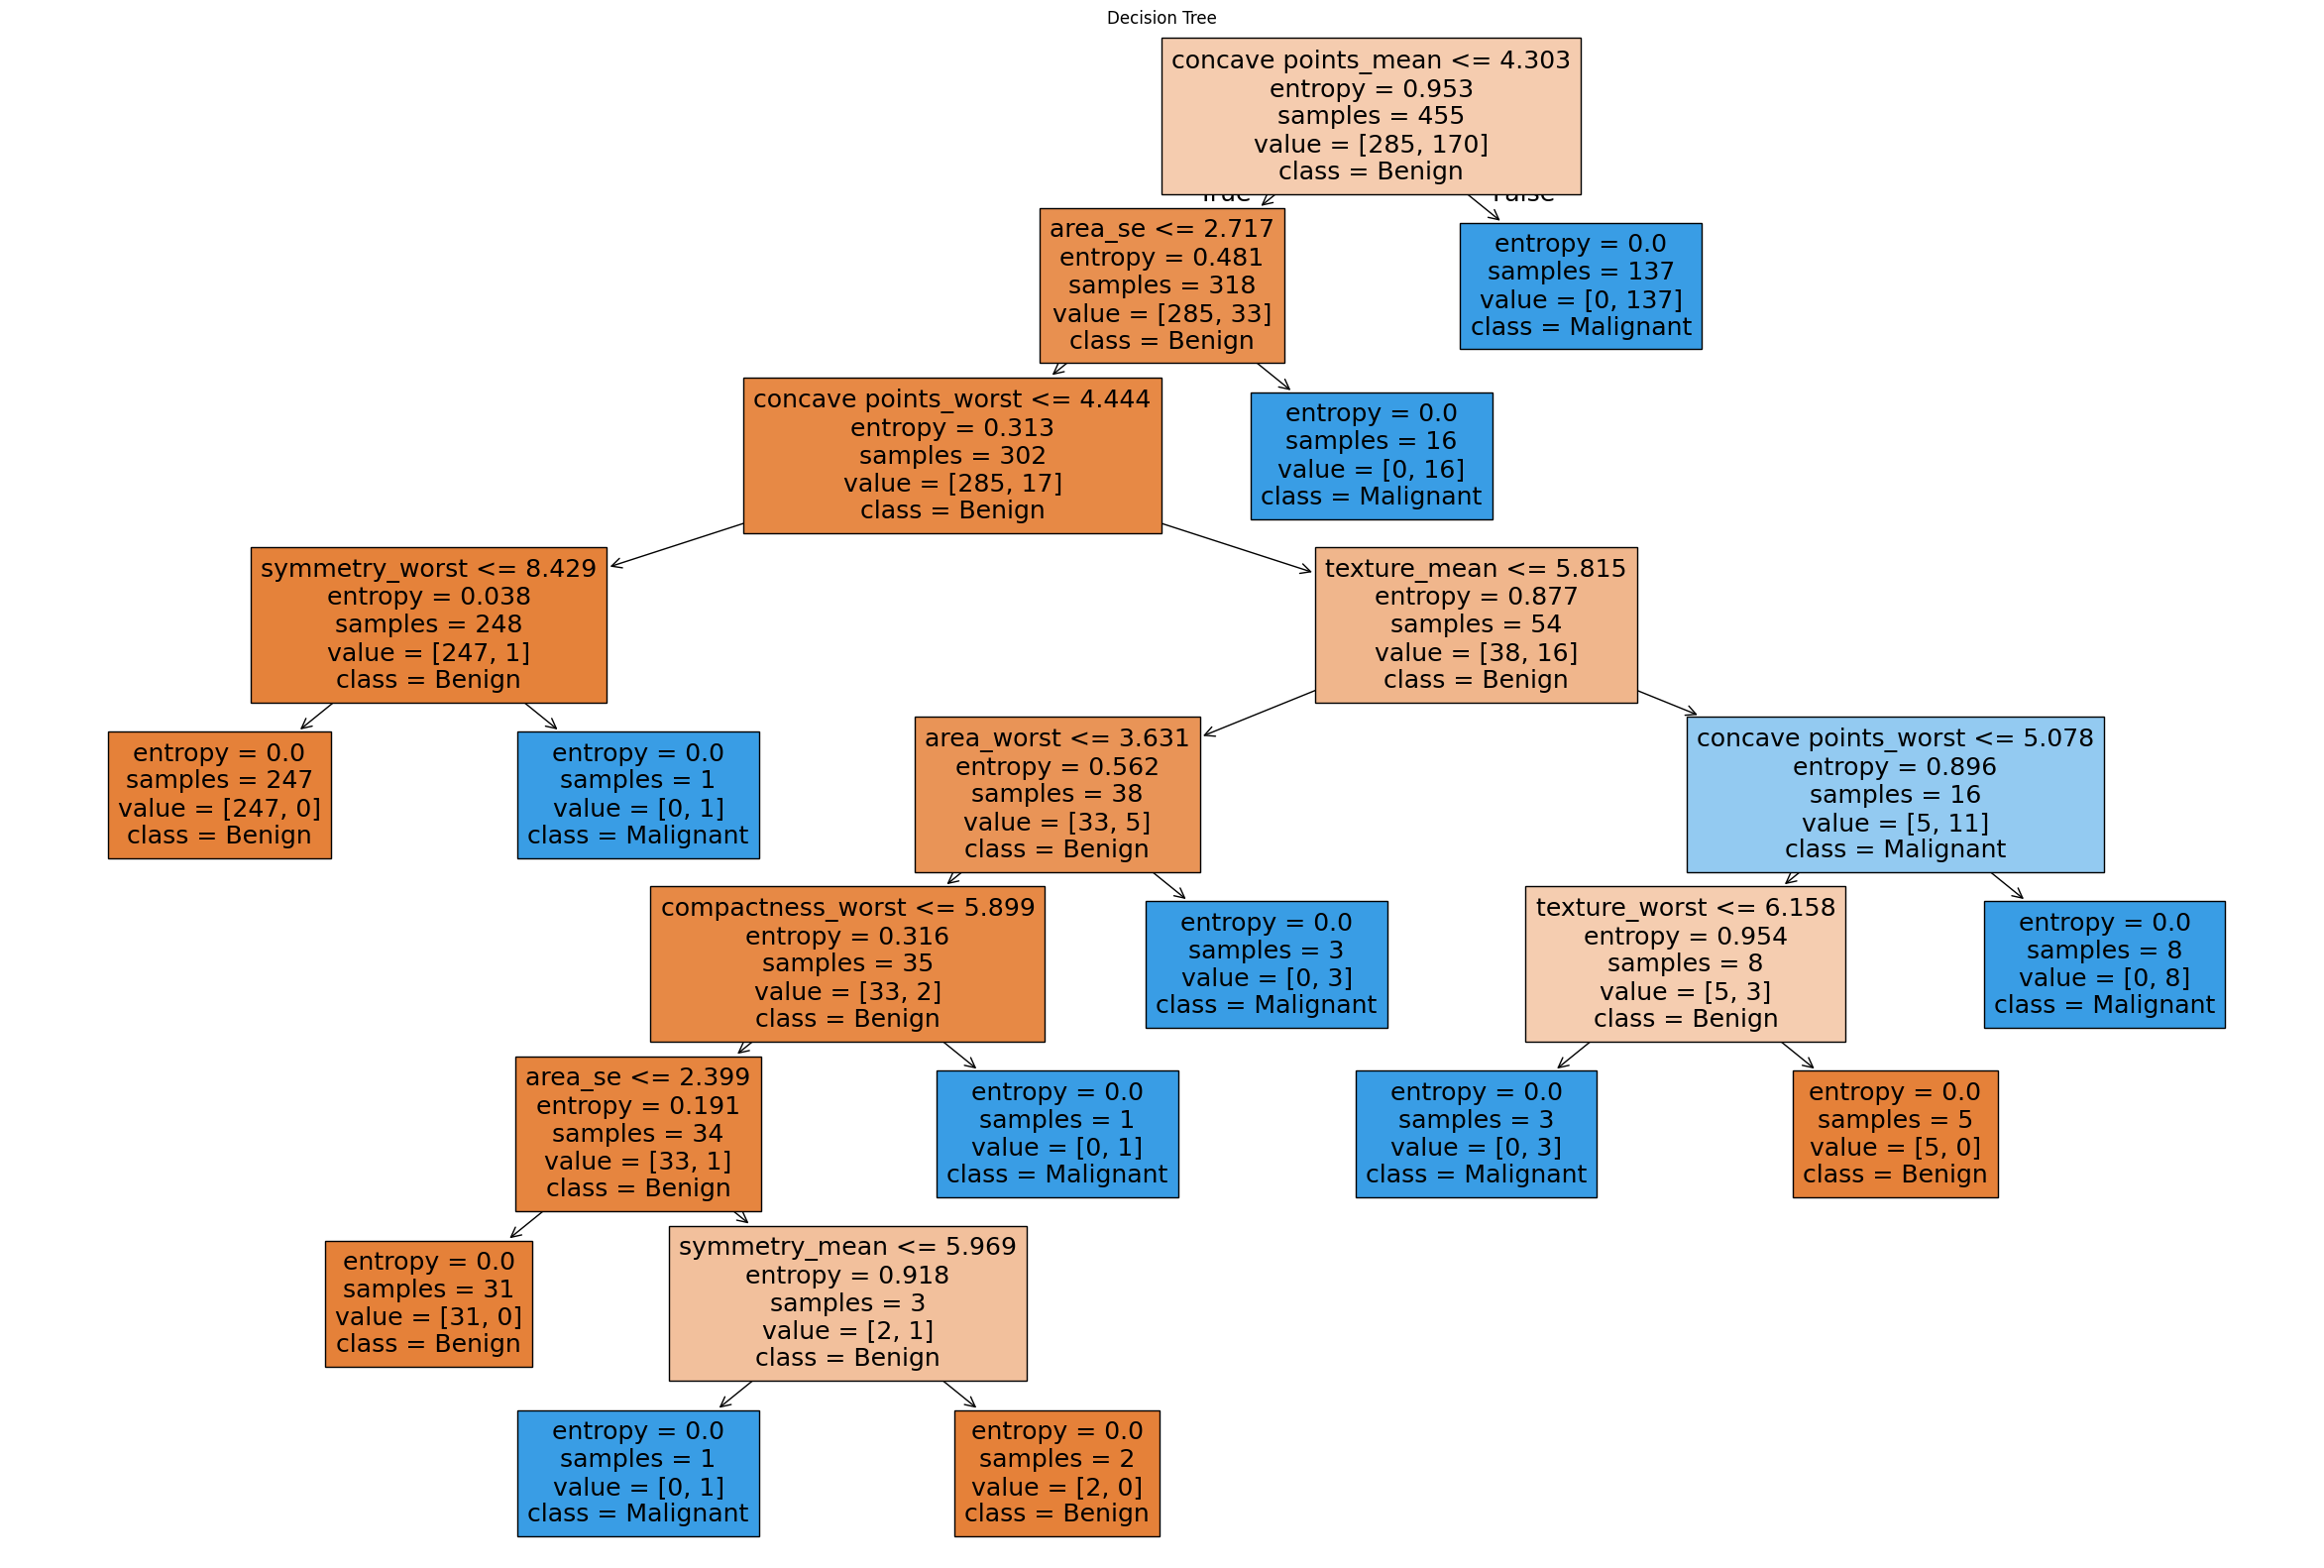

In [177]:
if OUTPUT:
    plt.figure(figsize=(30, 20))
    plot_tree(dt_model, feature_names=x.columns, class_names=['Benign', 'Malignant'], filled=True)
    plt.title("Decision Tree")
    plt.show()

#### Decision Tree Confusion Matrix & ROC Curve

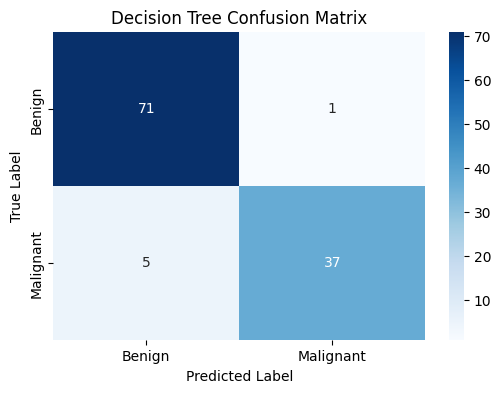

In [154]:
if OUTPUT:
    plot_confusion_matrix(y_test, y_pred, "Decision Tree Confusion Matrix")

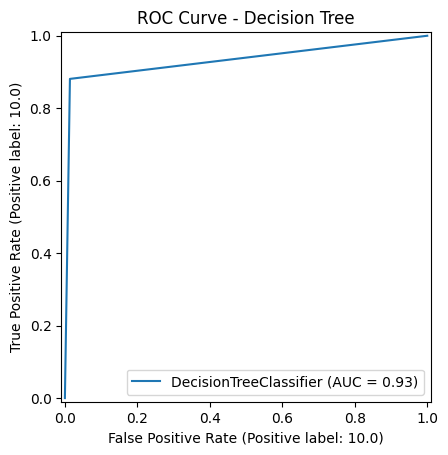

In [155]:
if OUTPUT:
    RocCurveDisplay.from_estimator(dt_model, x_test, y_test)
    plt.title("ROC Curve - Decision Tree")
    plt.show()

### K Nearest Neighbors

The Optimum value of K is: 10
Accuracy score = 95.61%
Classification Report:
              precision    recall  f1-score   support

         1.0       0.94      1.00      0.97        72
        10.0       1.00      0.88      0.94        42

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114



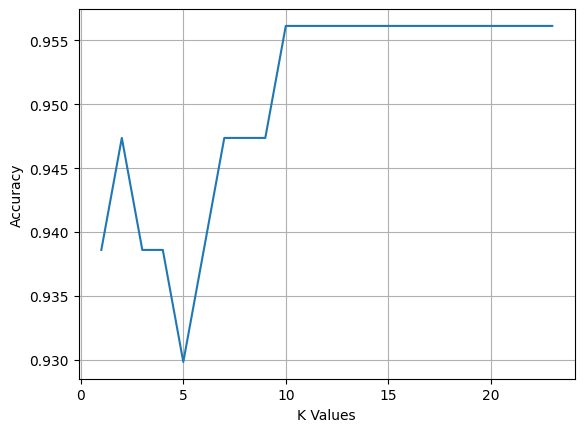

In [156]:
# Try different K and choose the best one according to accuracy
knn_acc_scores = []
K_RANGES = (1, 23)
for i in range(K_RANGES[0], K_RANGES[1] + 1):
    knn_model = KNeighborsClassifier(n_neighbors=i)
    knn_model.fit(x_train, y_train)
    y_pred = knn_model.predict(x_test)
    accuracy = accuracy_score(y_pred, y_test)
    knn_acc_scores.append(accuracy)
    
best_accuracy = np.amax(knn_acc_scores) * 100
optimum_k = K_RANGES[0] + np.argmax(knn_acc_scores)

accuracy_scores['KNN'] = best_accuracy

knn_model = KNeighborsClassifier(n_neighbors=optimum_k)
knn_model.fit(x_train, y_train)

y_pred = knn_model.predict(x_test)

if OUTPUT:
    print(f"The Optimum value of K is: {optimum_k}")
    print(f"Accuracy score = {best_accuracy:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    k_values = list(range(K_RANGES[0], K_RANGES[1] + 1))
    plt.plot(k_values, knn_acc_scores)
    plt.xlabel('K Values')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

#### KNN Confusion Matrix

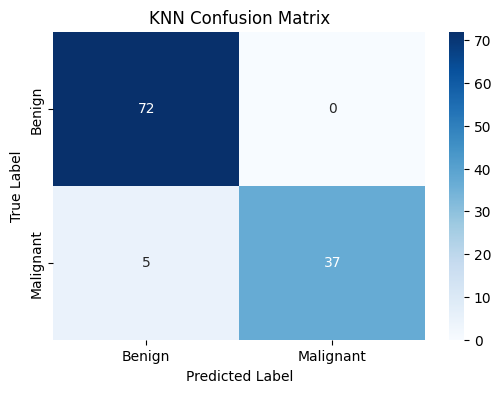

In [157]:
if OUTPUT:
    plot_confusion_matrix(y_test, y_pred, "KNN Confusion Matrix")

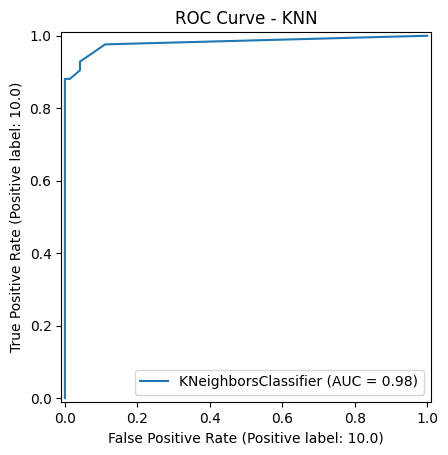

In [158]:
if OUTPUT:
    RocCurveDisplay.from_estimator(knn_model, x_test, y_test)
    plt.title("ROC Curve - KNN")
    plt.show()

### Gaussian Naive Bayes

In [159]:
nb_model = GaussianNB()
nb_model.fit(x_train, y_train)

y_pred = nb_model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred) * 100
accuracy_scores['GaussianNaiveBayes'] = accuracy

if OUTPUT:
    print(f"Accuracy: {accuracy:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

Accuracy: 92.98%
Classification Report:
              precision    recall  f1-score   support

         1.0       0.93      0.96      0.95        72
        10.0       0.93      0.88      0.90        42

    accuracy                           0.93       114
   macro avg       0.93      0.92      0.92       114
weighted avg       0.93      0.93      0.93       114



#### Confusion Matrix & ROC Curve

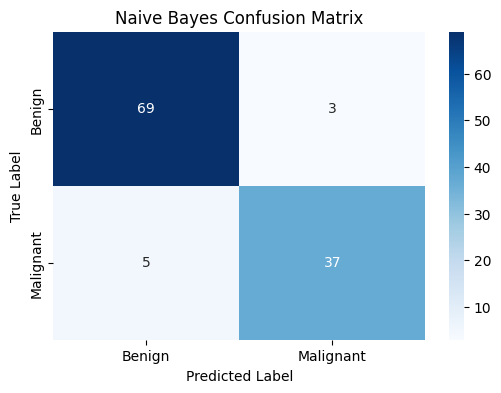

In [160]:
if OUTPUT:
    plot_confusion_matrix(y_test, y_pred, "Naive Bayes Confusion Matrix")

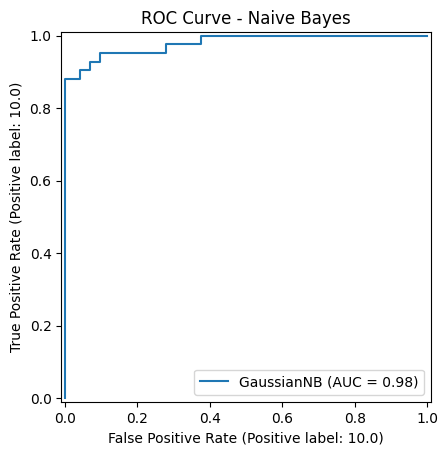

In [161]:
if OUTPUT:
    RocCurveDisplay.from_estimator(nb_model, x_test, y_test)
    plt.title("ROC Curve - Naive Bayes")
    plt.show()

### Random Forest Classifier

In [162]:
params = {
    'max_depth': [None, 10, 20, 30],
    'n_estimators': [50, 100],
    'max_features': [None, 5, 10, 15, 20]
}

rf_model = RandomForestClassifier(random_state=42)

# Search for the best parameters according to the depth of each tree, the number of trees, and the maximum number of features to use at each split
grid_search = GridSearchCV(estimator=rf_model, param_grid=params)
grid_search.fit(x_train, y_train)

rf_model = grid_search.best_estimator_

y_pred = rf_model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred) * 100

accuracy_scores['DecisionForest'] = accuracy

if OUTPUT:
    print("The best paramters are:")
    print(f"\tMaximum Depth: {grid_search.best_params_['max_depth']}")
    print(f"\tNumber of Trees: {grid_search.best_params_['n_estimators']}")
    print(f"\tMaximum Number of features to use at each split: {grid_search.best_params_['max_features']}")
    print(f"Accuracy: {accuracy:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

The best paramters are:
	Maximum Depth: None
	Number of Trees: 100
	Maximum Number of features to use at each split: 5
Accuracy: 95.61%
Classification Report:
              precision    recall  f1-score   support

         1.0       0.94      1.00      0.97        72
        10.0       1.00      0.88      0.94        42

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114



#### Confusion Matrix and ROC Curve

In [163]:
if OUTPUT:
     (y_test, y_pred, "Random Forest Confusion Matrix")

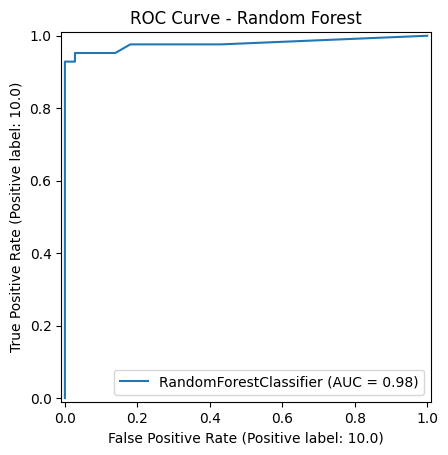

In [164]:
if OUTPUT:
    RocCurveDisplay.from_estimator(rf_model, x_test, y_test)
    plt.title("ROC Curve - Random Forest")
    plt.show()

## SVM (Support Vector Machine)

In [165]:
from sklearn.svm import SVC

params = {
    'kernel': ['linear', 'rbf']
}

# Search for the best parameters by changing the kernel 
svm_model = SVC()
grid_search = GridSearchCV(estimator=svm_model, param_grid=params)
grid_search.fit(x_train, y_train)

svm_model = grid_search.best_estimator_

y_pred = svm_model.predict(x_test)


accuracy = accuracy_score(y_test, y_pred) * 100

accuracy_scores['SVM'] = accuracy

if OUTPUT:
    print(f"The optimum kernel: {grid_search.best_params_['kernel']}")
    print(f"Acuuracy: {accuracy}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

The optimum kernel: rbf
Acuuracy: 95.6140350877193
Classification Report:
              precision    recall  f1-score   support

         1.0       0.94      1.00      0.97        72
        10.0       1.00      0.88      0.94        42

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114



#### Confusion Matrix & ROC Curve

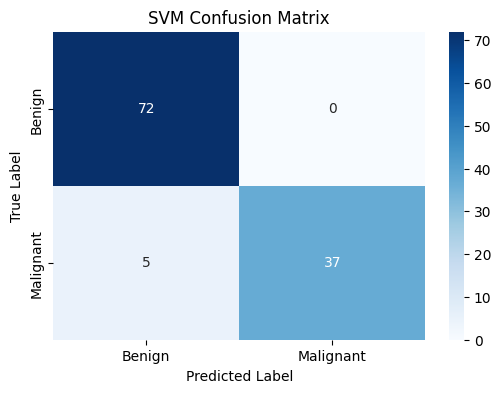

In [166]:
if OUTPUT:
    plot_confusion_matrix(y_test, y_pred, "SVM Confusion Matrix")

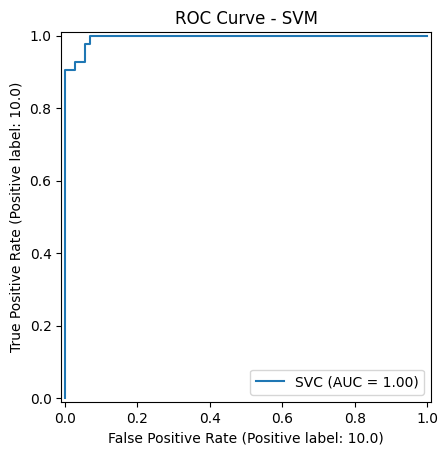

In [167]:
if OUTPUT:
    RocCurveDisplay.from_estimator(svm_model, x_test, y_test)
    plt.title("ROC Curve - SVM")
    plt.show()

### Visualizing Model Accuracies

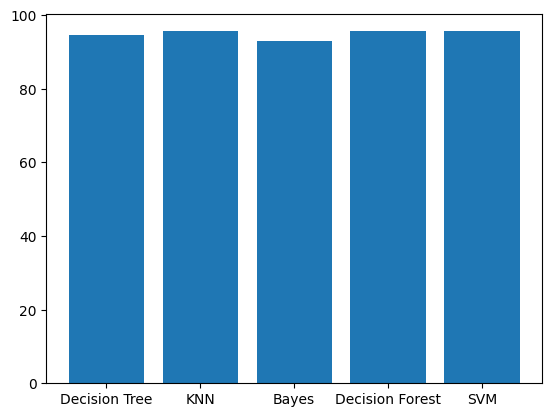

In [168]:
models = ['Decision Tree', 'KNN', 'Bayes', 'Decision Forest', 'SVM']
scores = list(accuracy_scores.values())

if OUTPUT:
    plt.bar(models, scores)

In [174]:
from collections import Counter

y_pred = []
y_pred_knn = knn_model.predict(x_test)
y_pred_decision_tree = dt_model.predict(x_test)
y_pred_bayes = nb_model.predict(x_test)
y_pred_forest = rf_model.predict(x_test)
y_pred_svm = svm_model.predict(x_test)

for i in range(len(y_pred_knn)):
    outs = [y_pred_knn[i], y_pred_decision_tree[i], y_pred_bayes[i], y_pred_forest[i], y_pred_svm[i]]
    ctr = Counter(outs)
    y_pred.append(ctr.most_common(1)[0][0])
    
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.956140350877193
